In [1]:
# importing libraries
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import json 
import requests 
from pandas.io.json import json_normalize 
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
from bs4 import BeautifulSoup
import lxml
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


# Step 1 - Getting, and cleaning the data
### Borough and subdistricts of Oslo

In [2]:
raw_xls_data=pd.read_excel('Desktop/oslo.xls')
type(raw_xls_data)

pandas.core.frame.DataFrame

In [3]:
raw_xls_data.head()

,SubDistrict,Borough
0,Ellingsrud,Alna
1,Furuset,Alna
2,Teisen,Alna
3,Hellerudtoppen,Alna
4,Lindeberg,Alna


In [4]:
# Combining sub-districts belonging to same borough 
df = raw_xls_data.groupby(['Borough'], sort=False).agg(', '.join)
df.reset_index(inplace=True)
df

,Borough,SubDistrict
0,Alna,"Ellingsrud, Furuset, Teisen, Hellerudtoppen, L..."
1,Bjerke,"Linderud, Årvoll, Veitvet, Økern"
2,Gamle Oslo,"Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Ka..."
3,Grorud,"Ammerud, Grorud, Rødtvet, Nordtvet , Romsås"
4,Vestre Aker,"Holmenkollen, Hovseter, Holmen , Vinderen, Røa..."
5,Grünerløkka,"Grünerløkka vest, Grünerløkka øst, Dælenenga, ..."
6,Sagene,"Iladalen, Sagene, Bjølsen, Sanaker, Torshov"
7,St. Hanshaugen,"Hammersborg, Bislett, ila , Fagenborg, Lindern"
8,Frogner,"Bygdøy, Frogner, Frognerparken, Majorstuem nor..."
9,Ullern,"Ullernåsen, Lilleaker, Ullern, Montebello_Hoff..."


In [5]:
df1=df.rename(columns={'SubDistrict': 'Neighborhoods'})
df1.head()

,Borough,Neighborhoods
0,Alna,"Ellingsrud, Furuset, Teisen, Hellerudtoppen, L..."
1,Bjerke,"Linderud, Årvoll, Veitvet, Økern"
2,Gamle Oslo,"Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Ka..."
3,Grorud,"Ammerud, Grorud, Rødtvet, Nordtvet , Romsås"
4,Vestre Aker,"Holmenkollen, Hovseter, Holmen , Vinderen, Røa..."


In [6]:
# Adding geospatial data

from opencage.geocoder import OpenCageGeocode

key = '9ebd04ad8f0f447985c9bf9a40a99560' 
geocoder = OpenCageGeocode(key)

list_lat = []   # create empty lists
list_long = []

for index, row in df1.iterrows(): # iterate over rows in dataframe

    Borough = row['Borough']      
    query = str(Borough)

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

# create new columns from lists    

df1['lat'] = list_lat   
df1['long'] = list_long

In [7]:
df1

,Borough,Neighborhoods,lat,long
0,Alna,"Ellingsrud, Furuset, Teisen, Hellerudtoppen, L...",59.932417,10.835276
1,Bjerke,"Linderud, Årvoll, Veitvet, Økern",59.941395,10.829209
2,Gamle Oslo,"Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Ka...",59.899237,10.734767
3,Grorud,"Ammerud, Grorud, Rødtvet, Nordtvet , Romsås",59.961424,10.880549
4,Vestre Aker,"Holmenkollen, Hovseter, Holmen , Vinderen, Røa...",59.958300,10.670319
5,Grünerløkka,"Grünerløkka vest, Grünerløkka øst, Dælenenga, ...",59.925471,10.777421
6,Sagene,"Iladalen, Sagene, Bjølsen, Sanaker, Torshov",59.938273,10.765849
7,St. Hanshaugen,"Hammersborg, Bislett, ila , Fagenborg, Lindern",59.927950,10.738958
8,Frogner,"Bygdøy, Frogner, Frognerparken, Majorstuem nor...",59.922224,10.706649
9,Ullern,"Ullernåsen, Lilleaker, Ullern, Montebello_Hoff...",59.925818,10.665132


### Scraping Wikipedia - Boroughs and popuplation Oslo

In [8]:
# Scrape Wikipedia table
source = requests.get('https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo').text
soup=BeautifulSoup(source,'lxml')
table=soup.find('table')
print(soup.title)
from IPython.display import display_html
tab = str(soup.table)
display_html(tab,raw=True)

<title>List of boroughs of Oslo - Wikipedia</title>


Borough,Residents,Area,Number
Alna,49 801,"13,7 km2",12
Bjerke,33 422,"7,7 km2",9
Frogner,59 269,"8,3 km2",5
Gamle Oslo,58 671,"7,5 km2",1
Grorud,27 707,"8,2 km2",10
Grünerløkka,62 423,"4,8 km2",2
Nordre Aker,52 327,"13,6 km2",8
Nordstrand,52 459,"16,9 km2",14
Sagene,45 089,"3,1 km2",3
St. Hanshaugen,38 945,"3,6 km2",4


In [9]:
# cleaning the table for the columns I need
dfs = pd.read_html(tab)
df_pop=dfs[0]
df_pop.columns =['Borough', 'Population', 'Area', 'Number'] 
df2=df_pop.drop(['Area', 'Number'], axis=1)
df2.drop([0])

,Borough,Population
1,Bjerke,33 422
2,Frogner,59 269
3,Gamle Oslo,58 671
4,Grorud,27 707
5,Grünerløkka,62 423
6,Nordre Aker,52 327
7,Nordstrand,52 459
8,Sagene,45 089
9,St. Hanshaugen,38 945
10,Stovner,33 316


In [10]:
# cleaning the table for the columns I need
dfs = pd.read_html(tab)
df_pop=dfs[0]
df_pop.columns =['Borough', 'Population', 'Area', 'Number'] 
df2=df_pop.drop(['Area', 'Number'], axis=1)
df2.drop([0])

,Borough,Population
1,Bjerke,33 422
2,Frogner,59 269
3,Gamle Oslo,58 671
4,Grorud,27 707
5,Grünerløkka,62 423
6,Nordre Aker,52 327
7,Nordstrand,52 459
8,Sagene,45 089
9,St. Hanshaugen,38 945
10,Stovner,33 316


In [11]:
raw=pd.read_excel('Desktop/Population_Oslo.xls')
type(raw)

pandas.core.frame.DataFrame

In [12]:
df2=raw
df2

,Borough,Population
0,Gamle Oslo,58713
1,Grünerløkka,62409
2,Sagene,45053
3,St. Hanshaugen,40321
4,Frogner,59292
5,Ullern,34500
6,Vestre Aker,50876
7,Nordre Aker,53206
8,Bjerke,33491
9,Grorud,27630


In [13]:
# Merging df1 & df2 into 1 dataframe "df_oslo"
df1.columns =['Borough', 'Neighborhoods', 'lat', 'long'] 
df1.set_index('Borough')
df2.set_index('Borough')
df_oslo=pd.merge(df1, df2)
df_oslo.head(10)

,Borough,Neighborhoods,lat,long,Population
0,Alna,"Ellingsrud, Furuset, Teisen, Hellerudtoppen, L...",59.932417,10.835276,49834
1,Bjerke,"Linderud, Årvoll, Veitvet, Økern",59.941395,10.829209,33491
2,Gamle Oslo,"Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Ka...",59.899237,10.734767,58713
3,Grorud,"Ammerud, Grorud, Rødtvet, Nordtvet , Romsås",59.961424,10.880549,27630
4,Vestre Aker,"Holmenkollen, Hovseter, Holmen , Vinderen, Røa...",59.958300,10.670319,50876
5,Grünerløkka,"Grünerløkka vest, Grünerløkka øst, Dælenenga, ...",59.925471,10.777421,62409
6,Sagene,"Iladalen, Sagene, Bjølsen, Sanaker, Torshov",59.938273,10.765849,45053
7,St. Hanshaugen,"Hammersborg, Bislett, ila , Fagenborg, Lindern",59.927950,10.738958,40321
8,Frogner,"Bygdøy, Frogner, Frognerparken, Majorstuem nor...",59.922224,10.706649,59292
9,Ullern,"Ullernåsen, Lilleaker, Ullern, Montebello_Hoff...",59.925818,10.665132,34500


### Visualizing boroughs in Oslo

In [14]:
# getting Oslo's coordinate
from geopy.geocoders import Nominatim
address = 'Oslo, Norway'
geolocator = Nominatim(user_agent="oslo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Oslo, Norway are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Oslo, Norway are 59.9133301, 10.7389701.


In [15]:
# Creating a map of Oslo using latitude and longitude values
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhoods in zip(df1['lat'], df1['long'], df1['Borough'], df1['Neighborhoods']):
    label = '{}, {}'.format(neighborhoods, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo) 
    
map_oslo

### Reading property price data in Oslo

In [16]:
sqm_data=pd.read_excel('Desktop/price_sqm.xls')
type(sqm_data)

pandas.core.frame.DataFrame

In [17]:
sqm_data.head()

,Unnamed: 0,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Gamle Oslo,34845,35452,37584,42045,46181,48421,50255,57329,68730,73181,74605
1,Grünerløkka,36440,37314,40084,44456,48990,51078,53173,60548,71505,75909,76413
2,Sagene,37390,38812,41273,46450,51625,53733,55362,63422,74206,79348,80766
3,St. Hanshaugen,40942,41759,44969,50247,54898,57328,58065,65631,76307,82436,81649
4,Frogner,44180,45150,49273,54552,58995,61100,61839,68158,79721,87326,87923


In [18]:
# assigning column name
sqm_data.rename(columns={'Unnamed: 0':'Borough'}, inplace=True)
sqm_data.head()

,Borough,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Gamle Oslo,34845,35452,37584,42045,46181,48421,50255,57329,68730,73181,74605
1,Grünerløkka,36440,37314,40084,44456,48990,51078,53173,60548,71505,75909,76413
2,Sagene,37390,38812,41273,46450,51625,53733,55362,63422,74206,79348,80766
3,St. Hanshaugen,40942,41759,44969,50247,54898,57328,58065,65631,76307,82436,81649
4,Frogner,44180,45150,49273,54552,58995,61100,61839,68158,79721,87326,87923


In [28]:
# dropping columns we don't need
df_price=sqm_data.drop(['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'], axis=1)
df_price

,Borough,2018
0,Gamle Oslo,74605
1,Grünerløkka,76413
2,Sagene,80766
3,St. Hanshaugen,81649
4,Frogner,87923
5,Ullern,74109
6,Vestre Aker,67186
7,Nordre Aker,78073
8,Bjerke,58834
9,Grorud,49224


In [44]:
df_sqm=df_price.rename(columns={'2018': 'Sqm_price'})
df_sqm.head()

,Borough,Sqm_price
0,Gamle Oslo,74605
1,Grünerløkka,76413
2,Sagene,80766
3,St. Hanshaugen,81649
4,Frogner,87923


In [46]:
# Merging df_oslo & df_price into 1 dataframe "df_3"
df_oslo.columns =['Borough', 'Neighborhoods', 'lat', 'long', 'Population'] 
df_oslo.set_index('Borough')
df_sqm.set_index('Borough')
df3=pd.merge(df_oslo, df_sqm)
df3.head(10)

,Borough,Neighborhoods,lat,long,Population,Sqm_price
0,Alna,"Ellingsrud, Furuset, Teisen, Hellerudtoppen, L...",59.932417,10.835276,49834,49042
1,Bjerke,"Linderud, Årvoll, Veitvet, Økern",59.941395,10.829209,33491,58834
2,Gamle Oslo,"Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Ka...",59.899237,10.734767,58713,74605
3,Grorud,"Ammerud, Grorud, Rødtvet, Nordtvet , Romsås",59.961424,10.880549,27630,49224
4,Vestre Aker,"Holmenkollen, Hovseter, Holmen , Vinderen, Røa...",59.958300,10.670319,50876,67186
5,Grünerløkka,"Grünerløkka vest, Grünerløkka øst, Dælenenga, ...",59.925471,10.777421,62409,76413
6,Sagene,"Iladalen, Sagene, Bjølsen, Sanaker, Torshov",59.938273,10.765849,45053,80766
7,St. Hanshaugen,"Hammersborg, Bislett, ila , Fagenborg, Lindern",59.927950,10.738958,40321,81649
8,Frogner,"Bygdøy, Frogner, Frognerparken, Majorstuem nor...",59.922224,10.706649,59292,87923
9,Ullern,"Ullernåsen, Lilleaker, Ullern, Montebello_Hoff...",59.925818,10.665132,34500,74109


In [59]:
df_merge = df3[['Borough', 'lat', 'long', 'Neighborhoods', 'Population', 'Sqm_price']]
df_merge.head()

,Borough,lat,long,Neighborhoods,Population,Sqm_price
0,Alna,59.932417,10.835276,"Ellingsrud, Furuset, Teisen, Hellerudtoppen, L...",49834,49042
1,Bjerke,59.941395,10.829209,"Linderud, Årvoll, Veitvet, Økern",33491,58834
2,Gamle Oslo,59.899237,10.734767,"Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Ka...",58713,74605
3,Grorud,59.961424,10.880549,"Ammerud, Grorud, Rødtvet, Nordtvet , Romsås",27630,49224
4,Vestre Aker,59.958300,10.670319,"Holmenkollen, Hovseter, Holmen , Vinderen, Røa...",50876,67186


# Step 2 - Visualizing the data

### Visualizing price development per square meter 2008 - 2018

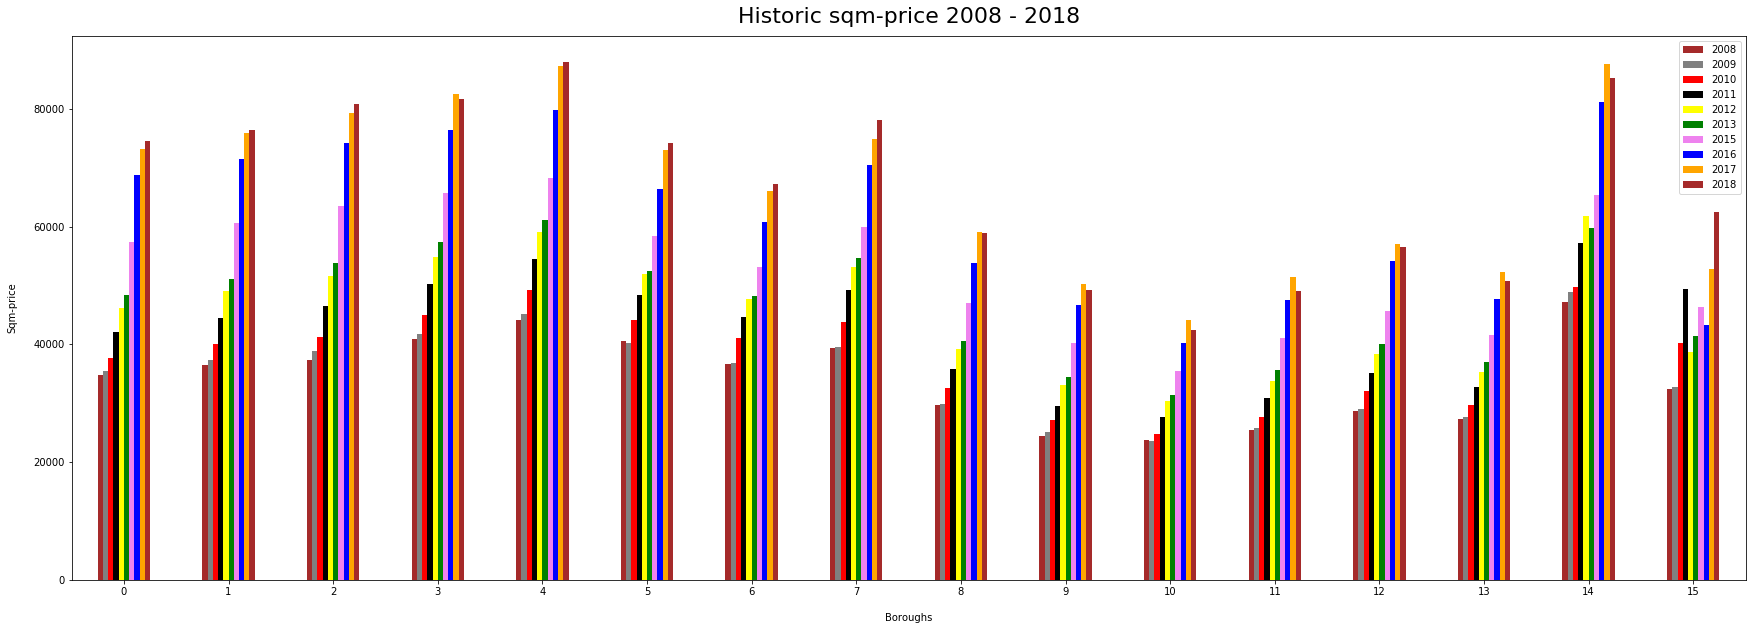

In [60]:
import matplotlib.pyplot as plt
sqm_data.plot(kind='bar', figsize=(30, 10), color=['brown', 'gray', 'red', 'black', 'yellow', 'green', 'violet', 'blue', 'orange'], rot=0)                                       
plt.title("Historic sqm-price 2008 - 2018", y=1.013, fontsize=22)
plt.xlabel("Boroughs", labelpad=16)
plt.ylabel("Sqm-price", labelpad=16);

### Visualizing population pr. borough (2020)

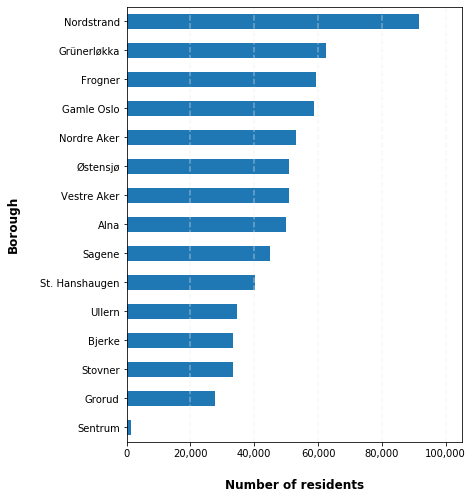

In [61]:
from matplotlib.ticker import StrMethodFormatter
dfx = df_osl.groupby('Borough')['Population'].mean().sort_values().tail(16)
dfp = dfx.plot(kind='barh', figsize=(6, 8))
# Draw vertical axis lines
vals = dfp.get_xticks()
for tick in vals:
    dfp.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
# Set x-axis label
dfp.set_xlabel("Number of residents", labelpad=20, weight='bold', size=12)
# Set y-axis label
dfp.set_ylabel("Borough", labelpad=20, weight='bold', size=12)
# Format y-axis label
dfp.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [62]:
df_merge.describe()

,lat,long,Population,Sqm_price
count,15.000000,15.000000,15.000000,15.000000
mean,59.568879,10.648304,46176.200000,67518.400000
std,1.405928,0.498655,20023.163109,15051.000061
min,54.487378,8.865286,1471.000000,42394.000000
25%,59.916092,10.720708,33995.500000,53674.000000
50%,59.927950,10.756412,49834.000000,74109.000000
75%,59.947516,10.830978,55959.500000,79419.500000
max,59.962140,10.922823,91683.000000,87923.000000


# Step 3 - Foursquare
#### Using the Foursquare API to explore and segment boroughs

In [63]:
# Defining Foursquare credentials and version
CLIENT_ID = 'NHAZG22XJCWGJZ4UMX1NVLHZVKMKDY00T2IACCUMNB54RW30' 
CLIENT_SECRET = 'YBUJZXAXZML5U0R2SIOHPIGV3IEQZP2DXKNDO2VYZO1USDMZ' 
VERSION = '20200502' 
print('My credentials!')

My credentials!


#### Exploring the first borough in our dataframe.¶

Get the borough's name.

In [64]:
df_merge.loc[0, 'Borough']

'Alna'

In [65]:
# geting Alna's latitude and longitude values
borough_latitude = df_merge.loc[0, 'lat'] # borough latitude value
borough_longitude = df_merge.loc[0, 'long'] # borough longitude value

borough_name = df_merge.loc[0, 'Borough'] # borough name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))

Latitude and longitude values of Alna are 59.9324168, 10.8352756.


In [66]:
# Getting the top 50 venues that are in Alna within a radius of 500 meters. First, let's create the GET request URL. Name your URL url.
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=NHAZG22XJCWGJZ4UMX1NVLHZVKMKDY00T2IACCUMNB54RW30&client_secret=YBUJZXAXZML5U0R2SIOHPIGV3IEQZP2DXKNDO2VYZO1USDMZ&v=20200502&ll=59.9324168,10.8352756&radius=500&limit=100'

In [67]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ecabb0e211536001bddbfac'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Økern',
  'headerFullLocation': 'Økern, Oslo',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 59.9369168045, 'lng': 10.844240495559186},
   'sw': {'lat': 59.927916795499996, 'lng': 10.826310704440813}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fdae638e4b0631afd25aea4',
       'name': 'BROBEKK STORCASH AS',
       'location': {'address': 'Brobekkveien 80',
        'lat': 59.932201245134564,
        'lng': 10.831548263005034,
        'labeledLatLngs': [{'label': 'display',
 

In [68]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [69]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,BROBEKK STORCASH AS,Grocery Store,59.932201,10.831548
1,Vollebekk (B),Bus Station,59.935928,10.831141
2,Vollebekk (T),Metro Station,59.935934,10.831086


In [70]:
# venues returned by Foursquare
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


#### Exploring boroughs in Oslo

In [78]:
# We create a function to repeat the same process to all the boroughs in Oslo
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [81]:
oslo_venues = getNearbyVenues(names = df_merge['Borough'],  
                                   latitudes = df_merge['lat'],
                                   longitudes = df_merge['long']
                                  )

Alna
Bjerke
Gamle Oslo
Grorud
Vestre Aker
Grünerløkka
Sagene
St. Hanshaugen
Frogner
Ullern
Nordre Aker
Stovner
Østensjø
Nordstrand
Sentrum


In [82]:
# Size of the resulting dataframe
print(oslo_venues.shape)
oslo_venues.head()

(250, 7)


,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alna,59.932417,10.835276,BROBEKK STORCASH AS,59.932201,10.831548,Grocery Store
1,Alna,59.932417,10.835276,Vollebekk (B),59.935928,10.831141,Bus Station
2,Alna,59.932417,10.835276,Vollebekk (T),59.935934,10.831086,Metro Station
3,Bjerke,59.941395,10.829209,SATS,59.943087,10.835261,Gym / Fitness Center
4,Bjerke,59.941395,10.829209,Thon Hotel Linne,59.939471,10.829001,Hotel


In [83]:
# Checking how many venues were returned for each borough
oslo_venues.groupby('Borough').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Alna,3,3,3,3,3,3
Bjerke,8,8,8,8,8,8
Frogner,28,28,28,28,28,28
Gamle Oslo,11,11,11,11,11,11
Grorud,8,8,8,8,8,8
Grünerløkka,15,15,15,15,15,15
Nordre Aker,7,7,7,7,7,7
Nordstrand,1,1,1,1,1,1
Sagene,29,29,29,29,29,29


# Step 4 - Modelling

#### One hot encoding to analyze each borough

In [84]:
# one hot encoding
oslo_onehot = pd.get_dummies(oslo_venues[['Venue Category']], prefix="", prefix_sep="")

# move Borough column to the first column
oslo_onehot['Borough'] = oslo_venues['Borough']

# move Borough column to the first column
fixed_columns = [oslo_onehot.columns[-1]] + list(oslo_onehot.columns[:-1])
oslo_onehot = oslo_onehot[fixed_columns]

oslo_onehot.head()

,Borough,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,Beer Bar,Bike Rental / Bike Share,Boarding House,Boat or Ferry,Bookstore,Burrito Place,Bus Station,Bus Stop,Café,Camera Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Exhibit,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Indian Restaurant,Italian Restaurant,Juice Bar,Light Rail Station,Market,Men's Store,Metro Station,Mexican Restaurant,Movie Theater,Music Venue,Nightclub,North Indian Restaurant,Other Nightlife,Pakistani Restaurant,Park,Performing Arts Venue,Pet Store,Pier,Pizza Place,Playground,Plaza,Pub,Record Shop,Restaurant,Road,Salad Place,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Shopping Mall,Ski Area,Soccer Field,Soup Place,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Tourist Information Center,Tram Station,Video Game Store,Video Store,Whisky Bar,Wine Shop
0,Alna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bjerke,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bjerke,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
oslo_onehot.shape

(250, 93)

In [86]:
oslo_grouped = oslo_onehot.groupby('Borough').mean().reset_index()
oslo_grouped

,Borough,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,Beer Bar,Bike Rental / Bike Share,Boarding House,Boat or Ferry,Bookstore,Burrito Place,Bus Station,Bus Stop,Café,Camera Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Exhibit,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,French Restaurant,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Indian Restaurant,Italian Restaurant,Juice Bar,Light Rail Station,Market,Men's Store,Metro Station,Mexican Restaurant,Movie Theater,Music Venue,Nightclub,North Indian Restaurant,Other Nightlife,Pakistani Restaurant,Park,Performing Arts Venue,Pet Store,Pier,Pizza Place,Playground,Plaza,Pub,Record Shop,Restaurant,Road,Salad Place,Sandwich Place,Scandinavian Restaurant,Sculpture Garden,Shopping Mall,Ski Area,Soccer Field,Soup Place,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Tourist Information Center,Tram Station,Video Game Store,Video Store,Whisky Bar,Wine Shop
0,Alna,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.333333,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.333333,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.333333,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000
1,Bjerke,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.250000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.125,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.125,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.250000,0.125,0.000000,0.000000,0.00,0.125000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000
2,Frogner,0.00,0.00,0.035714,0.00,0.000000,0.00,0.035714,0.000000,0.000000,0.00,0.035714,0.000000,0.00,0.00,0.035714,0.000000,0.071429,0.00,0.000000,0.00,0.000000,0.035714,0.000000,0.000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000,0.000000,0.0,0.00,0.035714,0.035714,0.000000,0.00,0.071429,0.000000,0.000,0.000000,0.035714,0.00,0.071429,0.035714,0.071429,0.00,0.035714,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.035714,0.000000,0.00,0.035714,0.00,0.00,0.035714,0.071429,0.071429,0.000000,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.035714,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.035714
3,Gamle Oslo,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.363636,0.00,0.00,0.000000,0.000000,0.090909,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.090909,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.090909,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.090909,0.00,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.090909,0.000000,0.000000,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.00000

In [87]:
oslo_grouped.shape

(14, 93)

Top 5 most common venues across boroughs

In [88]:
# Let's print each borough along with the top 5 most common venues
num_top_venues = 5

for hood in oslo_grouped['Borough']:
    print("----"+hood+"----")
    temp = oslo_grouped[oslo_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alna----
                  venue  freq
0         Metro Station  0.33
1         Grocery Store  0.33
2           Bus Station  0.33
3   American Restaurant  0.00
4  Pakistani Restaurant  0.00


----Bjerke----
                  venue  freq
0         Grocery Store  0.25
1                  Café  0.25
2     Convenience Store  0.12
3                 Hotel  0.12
4  Fast Food Restaurant  0.12


----Frogner----
                     venue  freq
0                     Café  0.07
1       Italian Restaurant  0.07
2         Sculpture Garden  0.07
3  Scandinavian Restaurant  0.07
4             Gourmet Shop  0.07


----Gamle Oslo----
             venue  freq
0    Boat or Ferry  0.36
1             Pier  0.18
2  Other Nightlife  0.09
3           Market  0.09
4    Historic Site  0.09


----Grorud----
           venue  freq
0  Grocery Store  0.25
1      Wine Shop  0.12
2    Supermarket  0.12
3    Pizza Place  0.12
4   Soccer Field  0.12


----Grünerløkka----
                  venue  freq
0  Gym / Fitness

Create a new dataframe displaying the 10 venues for each borough

In [89]:
# We create a new dataframe and display the top 10 venues for each borough.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [90]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = oslo_grouped['Borough']

for ind in np.arange(oslo_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(oslo_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,Grocery Store,Metro Station,Bus Station,Wine Shop,Fish Market,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
1,Bjerke,Grocery Store,Café,Hotel,Gym / Fitness Center,Convenience Store,Fast Food Restaurant,Fish Market,Department Store,Dessert Shop,Dim Sum Restaurant
2,Frogner,Hotel,Café,Sculpture Garden,Italian Restaurant,Gourmet Shop,Scandinavian Restaurant,Bus Station,Coffee Shop,French Restaurant,Restaurant
3,Gamle Oslo,Boat or Ferry,Pier,Market,Scandinavian Restaurant,Café,Other Nightlife,Historic Site,Gastropub,Furniture / Home Store,Gym / Fitness Center
4,Grorud,Grocery Store,Wine Shop,Supermarket,Pizza Place,Bus Station,Soccer Field,Convenience Store,Furniture / Home Store,Gastropub,Gym / Fitness Center


# Step 5 - Clustering Boroughs

In [92]:
from sklearn.cluster import KMeans
import sklearn.cluster.k_means_

In [94]:
# set number of cluster
kclusters = 3
# run k-means clustering
o_grouped_clustering = oslo_grouped.drop('Borough', 1)
# check cluster labels generated for each row in the dataframe
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(o_grouped_clustering)
kmeans.labels_[0:10]

array([0, 2, 2, 2, 0, 2, 0, 1, 2, 2], dtype=int32)

In [95]:
# add clustering labels
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boroughs = df_oslo

# merge toronto_grouped with toronto_data to add latitude/longitude for each borough
boroughs = boroughs.join(borough_venues_sorted.set_index('Borough'), on='Borough')
boroughs.head() 

,Borough,Neighborhoods,lat,long,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,"Ellingsrud, Furuset, Teisen, Hellerudtoppen, L...",59.932417,10.835276,49834,0.0,Grocery Store,Metro Station,Bus Station,Wine Shop,Fish Market,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
1,Bjerke,"Linderud, Årvoll, Veitvet, Økern",59.941395,10.829209,33491,2.0,Grocery Store,Café,Hotel,Gym / Fitness Center,Convenience Store,Fast Food Restaurant,Fish Market,Department Store,Dessert Shop,Dim Sum Restaurant
2,Gamle Oslo,"Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Ka...",59.899237,10.734767,58713,2.0,Boat or Ferry,Pier,Market,Scandinavian Restaurant,Café,Other Nightlife,Historic Site,Gastropub,Furniture / Home Store,Gym / Fitness Center
3,Grorud,"Ammerud, Grorud, Rødtvet, Nordtvet , Romsås",59.961424,10.880549,27630,0.0,Grocery Store,Wine Shop,Supermarket,Pizza Place,Bus Station,Soccer Field,Convenience Store,Furniture / Home Store,Gastropub,Gym / Fitness Center
4,Vestre Aker,"Holmenkollen, Hovseter, Holmen , Vinderen, Røa...",59.958300,10.670319,50876,0.0,Grocery Store,Restaurant,Metro Station,Ski Area,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


In [123]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boroughs['long'], boroughs['lat'], boroughs['Borough'], boroughs['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [109]:
boroughs.loc[boroughs['Cluster Labels'] == 0, boroughs.columns[[1] + list(range(3, boroughs.shape[1]))]]

,Neighborhoods,long,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Ellingsrud, Furuset, Teisen, Hellerudtoppen, L...",10.835276,49834,0.0,Grocery Store,Metro Station,Bus Station,Wine Shop,Fish Market,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
3,"Ammerud, Grorud, Rødtvet, Nordtvet , Romsås",10.880549,27630,0.0,Grocery Store,Wine Shop,Supermarket,Pizza Place,Bus Station,Soccer Field,Convenience Store,Furniture / Home Store,Gastropub,Gym / Fitness Center
4,"Holmenkollen, Hovseter, Holmen , Vinderen, Røa...",10.670319,50876,0.0,Grocery Store,Restaurant,Metro Station,Ski Area,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
10,"Disen, Myrer, Grefsen, Kjelsås, Korsvoll, Tåse...",10.756412,53206,0.0,Bus Stop,Bus Station,Grocery Store,Café,Shopping Mall,Wine Shop,Fast Food Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant
11,"Vestli, Fossum, Rommen, Haugenstua, Stovner, H...",10.922823,33259,0.0,Video Game Store,Grocery Store,Athletics & Sports,Shopping Mall,Wine Shop,Fish Market,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant


### Cluster 2

In [110]:
boroughs.loc[boroughs['Cluster Labels'] == 1, boroughs.columns[[1] + list(range(3, boroughs.shape[1]))]]

,Neighborhoods,long,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,"Ljan, Nordstrand, Bekkelaget, Simensbråten, La...",8.865286,91683,1.0,Bakery,Wine Shop,Food Court,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Exhibit,Fast Food Restaurant


### Cluster 3

In [111]:
boroughs.loc[boroughs['Cluster Labels'] == 2, boroughs.columns[[1] + list(range(3, boroughs.shape[1]))]]

,Neighborhoods,long,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Linderud, Årvoll, Veitvet, Økern",10.829209,33491,2.0,Grocery Store,Café,Hotel,Gym / Fitness Center,Convenience Store,Fast Food Restaurant,Fish Market,Department Store,Dessert Shop,Dim Sum Restaurant
2,"Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Ka...",10.734767,58713,2.0,Boat or Ferry,Pier,Market,Scandinavian Restaurant,Café,Other Nightlife,Historic Site,Gastropub,Furniture / Home Store,Gym / Fitness Center
5,"Grünerløkka vest, Grünerløkka øst, Dælenenga, ...",10.777421,62409,2.0,Gym / Fitness Center,Sushi Restaurant,Coffee Shop,Dog Run,Chinese Restaurant,Sports Bar,Bus Station,Bakery,Plaza,Asian Restaurant
6,"Iladalen, Sagene, Bjølsen, Sanaker, Torshov",10.765849,45053,2.0,Coffee Shop,Park,Bakery,Pizza Place,Sushi Restaurant,Concert Hall,Performing Arts Venue,Pet Store,Deli / Bodega,Pub
7,"Hammersborg, Bislett, ila , Fagenborg, Lindern",10.738958,40321,2.0,Bakery,Park,Coffee Shop,Café,Wine Shop,Beer Bar,Gourmet Shop,Gastropub,Italian Restaurant,French Restaurant
8,"Bygdøy, Frogner, Frognerparken, Majorstuem nor...",10.706649,59292,2.0,Hotel,Café,Sculpture Garden,Italian Restaurant,Gourmet Shop,Scandinavian Restaurant,Bus Station,Coffee Shop,French Restaurant,Restaurant
9,"Ullernåsen, Lilleaker, Ullern, Montebello_Hoff...",10.665132,34500,2.0,Light Rail Station,Bus Station,Convenience Store,Flower Shop,Wine Shop,Fish Market,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
14,Sentrum,10.743164,1471,2.0,Hotel,Coffee Shop,Restaurant,Scandinavian Restaurant,Bar,Café,Italian Restaurant,Indian Restaurant,Sushi Restaurant,Clothing Store
